In [1]:
library(pacman)
p_load(dplyr,glarma,boot)

In [2]:
setwd('C:\\Users\\Marcelo\\OneDrive\\Área de Trabalho\\ts\\glarma')
getwd()

[1] "C:/Users/Marcelo/OneDrive/Área de Trabalho/ts/glarma"

# Simulação

Criando a função que simula o processo:

In [3]:
simulate_glarma <- function(T = 100, beta = 1, phi = 0, theta = 0.3, x = NULL) {
  if (is.null(x)) x <- rep(1, T)
  
  z <- numeric(T)
  mu <- numeric(T)
  y <- numeric(T)
  e <- numeric(T)
  
  for (t in 1:T) {
    z_t <- 0
    if (t > 1) z_t <- z[t - 1] * phi + e[t - 1] * theta
    
    eta <- beta * x[t] + z_t
    mu[t] <- exp(eta)
    y[t] <- rpois(1, lambda = mu[t])
    e[t] <- (y[t] - mu[t]) / sqrt(mu[t])
    z[t] <- z_t
  }
  
  return(data.frame(time = 1:T, x = x, y = y, mu = mu, z = z,e=e))
}

In [4]:
Amostra_original<-simulate_glarma(T=100,beta=1,phi=0,theta=0.3,x=NULL)

In [5]:
length(Amostra_original$y)

[1] 100

In [6]:
summary(Amostra_original$y)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    2.00    3.00    2.77    4.00    8.00 

In [7]:
X <- Amostra_original$x
X <- as.matrix(X)
colnames(X) <- "Intercept"

In [8]:
result=glarma(Amostra_original$y, X, phiLags = NULL ,thetaLags = c(1), type = "Poi")

In [9]:
Theta<-result$delta[2]
Theta

theta_1 
0.2867504

In [10]:
Beta<-result$delta[1]
Beta

Intercept 
0.9871397

# Bootstrap paramétrico:

In [11]:
B=100

In [12]:
T=length(Amostra_original$y)

gerando as amostras bootstrap:

In [13]:
mu<-Amostra_original$mu

In [14]:
length(mu)

[1] 100

In [15]:
Y_Bootstrap <- matrix(NA, nrow = T, ncol = B)

In [16]:
for (b in 1:B){
    r = simulate_glarma(T=T,beta=1,phi=0,theta=Theta,x=NULL) 
    Y_Bootstrap[,b] <- r$y
    }

Estimando os parâmetros para cada amostra:

In [17]:
recupera_par<- function(Y_col){
    fit<-glarma(Y_col, X, phiLags = NULL ,thetaLags = c(1), type = "Poi")
    return(fit$delta[2])}

In [18]:
Theta_estimates <- apply(Y_Bootstrap, 2, recupera_par)

In [19]:
mean(Theta_estimates)

[1] 0.2992306

In [20]:
quantile(Theta_estimates,probs=c(0.025,0.975))

2.5%     97.5% 
0.2126547 0.3807427

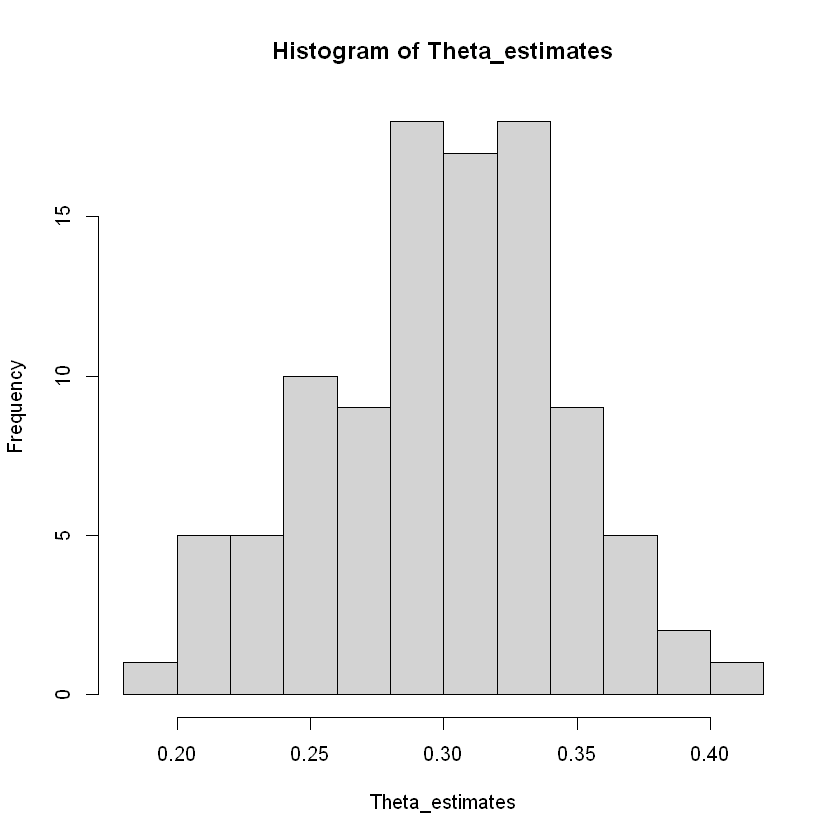

In [21]:
hist(Theta_estimates)

Nosso bootstrap está funcionando, vamos fazer o experimento monte carlo:

### Questão 1

In [22]:
R = 100

In [23]:
bootstrap_parametrico <- function(B=20,T=100,beta=1,phi=0,theta=0.3)

    {
    Theta_bootstrap<-numeric(B)

    Amostra_original<-simulate_glarma(T=100,beta=1,phi=0,theta=0.3,x=NULL)
    X <- Amostra_original$x
    X <- as.matrix(X)
    colnames(X) <- "Intercept"

    result=glarma(Amostra_original$y, X, phiLags = NULL ,thetaLags = c(1), type = "Poi")
    theta_estimado<-result$delta[2]

    T=length(Amostra_original$y)
    mu<-result$mu

    Y_Bootstrap <- matrix(NA, nrow = T, ncol = B)

    for (b in 1:B)
        {
        s = simulate_glarma(T=T,beta=beta,phi=0,theta=theta_estimado,x=NULL) 
        Y_Bootstrap[,b] <- s$y
        }
    
    Theta_bootstrap <- apply(Y_Bootstrap, 2, recupera_par)

    mean_theta <- mean(Theta_bootstrap)

    IC<-quantile(Theta_bootstrap, probs = c(0.025, 0.975))
            
    return(list('theta_estimado'=theta_estimado,
                'Theta_bootstrap'=Theta_bootstrap,
                'mean_theta'=mean_theta,
                'IC'=IC,
                'Amostra_original'= Amostra_original$y))
    }

In [24]:
Questao1 <- function(B = 20, T = 100, beta = 1, phi = 0, theta = 0.3, R = 2) {
  
  theta_estimado <- numeric(R)
  mean_theta_bootstrap <- numeric(R)
  IC_bootstrap <- vector("list", R)
  
  for (r in 1:R) {
    result <- tryCatch({
      bootstrap_parametrico(B = B, T = T, beta = beta, phi = phi, theta = theta)
    }, error = function(e) {
      message(sprintf("Erro na repetição %d: %s", r, e$message))
      return(NULL)
    })
    
    if (!is.null(result)) {
      mean_theta_bootstrap[r] <- result$mean_theta
      IC_bootstrap[[r]] <- result$IC
      theta_estimado[r] <- result$theta_estimado
    } else {
      mean_theta_bootstrap[r] <- NA
      IC_bootstrap[[r]] <- c(NA, NA)
      theta_estimado[r] <- NA
    }
  }
  
  return(list(
    'theta_estimado' = theta_estimado,
    'mean_theta_bootstrap' = mean_theta_bootstrap,
    'IC_bootstrap' = IC_bootstrap
  ))
}


conferindo as funções:

In [25]:
MM_bootstrap_parametrico<-Questao1()

In [26]:
MM_bootstrap_parametrico

$theta_estimado
[1] 0.3328339 0.2462838

$mean_theta_bootstrap
[1] 0.3479139 0.2285745

$IC_bootstrap
$IC_bootstrap[[1]]
     2.5%     97.5% 
0.2399775 0.4301383 

$IC_bootstrap[[2]]
     2.5%     97.5% 
0.1516014 0.2818695

Respondendo a questão:

In [29]:
conferindo_cobertura_bootstrap <- function(B = 20, T = 100, beta = 1, phi = 0, theta = 0.3, R = 100) {
  
  resultado <- Questao1(B = B, T = T, beta = beta, phi = phi, theta = theta, R = R)

  theta_estimado <- resultado$theta_estimado
  IC_bootstrap <- resultado$IC_bootstrap
  
  dentro_do_intervalo <- logical(R)
  
 for (r in 1:R) {
    intervalo <- IC_bootstrap[[r]]
    
    if (any(is.na(intervalo))) {
      dentro_do_intervalo[r] <- NA
    } else {
      dentro_do_intervalo[r] <- (theta >= intervalo[1]) && (theta <= intervalo[2])
    }
  }

  cobertura_percentual <- mean(dentro_do_intervalo, na.rm = TRUE) * 100
  
  return(list(
    cobertura_percentual = cobertura_percentual,
    total_dentro = sum(dentro_do_intervalo,na.rm=TRUE),
    total_r = sum(!is.na(dentro_do_intervalo))
  ))
}


In [30]:
conferindo_cobertura_bootstrap(R=100,B=40)

Erro na repetição 8: Fisher Scoring fails to converge from the initial estimates.

Erro na repetição 63: Fisher Scoring fails to converge from the initial estimates.

Erro na repetição 81: Fisher Scoring fails to converge from the initial estimates.

Erro na repetição 91: Fisher Scoring fails to converge from the initial estimates.

Erro na repetição 95: Fisher Scoring fails to converge from the initial estimates.



$cobertura_percentual
[1] 89.47368

$total_dentro
[1] 85

$total_r
[1] 95

# Bootstrap Não Paramétrico

In [51]:
e<-Amostra_original$e

In [52]:
y<-Amostra_original$y

In [53]:
mu<-Amostra_original$mu

In [54]:
X <- Amostra_original$x
X <- as.matrix(X)
colnames(X) <- "Intercept"

In [55]:
e_boot <- replicate(B, sample(e, size = T, replace = TRUE))

In [56]:
gera_y_boot <- function(e,mu)
{
    
    T <- length(e)
    y <- numeric(T)
    
    for (t in 1:T)
        {
        y[t] = mu[t] + e[t]*sqrt(mu[t])
        y[t] = round(y[t])
        }
    y[y < 1e-12] <- 0
    return(data.frame(y=y))
} 

In [57]:
est_bootstrap <- function(y,X)
{
    fit <- glarma(y, X, phiLags = NULL ,thetaLags = c(1), type = "Poi")
    beta <- fit$delta[1]
    theta <- fit$delta[2]
    
    return(par = c(beta,theta))
}

In [58]:
gera_mu_boot <- function(e,y,x,par)
{
    z <- numeric(T)

    beta <- par[1]
    theta <- par[2]
    
    for (t in 1:T) {
        z_t <- 0
        if (t > 1) z_t <-  e[t - 1] * theta

        eta <- beta * x[t] + z_t
        mu[t] <- exp(eta)
        z[t] <- z_t
      }
    return(mu)
}

In [61]:
bootstrap_n_parametrico <- function(e_boot, mu_init, y, X, B)
{

    T <- length(y)
    Y_Bootstrap <- matrix(NA, nrow = T, ncol = B)
    theta <- numeric(B)

    mu_current <- mu_init  
  
  for (b in 1:B) {
    e <- e_boot[, b]
    
    y_boot <- gera_y_boot(e, mu_current)
    y_boot<-y_boot$y
    Y_Bootstrap[, b] <- y_boot
    
    par <- est_bootstrap(y_boot, X)
    theta[b] <- par[2]
    
    mu_current <- gera_mu_boot(e=e, y=y_boot, x=X, par=par)
  }
   
  return(theta)
}

In [62]:
theta_bootstrap <- bootstrap_n_parametrico(e_boot=e_boot,mu=mu,y=y,X=X,B=B)

In [63]:
mean(theta_bootstrap)

[1] -0.008484537

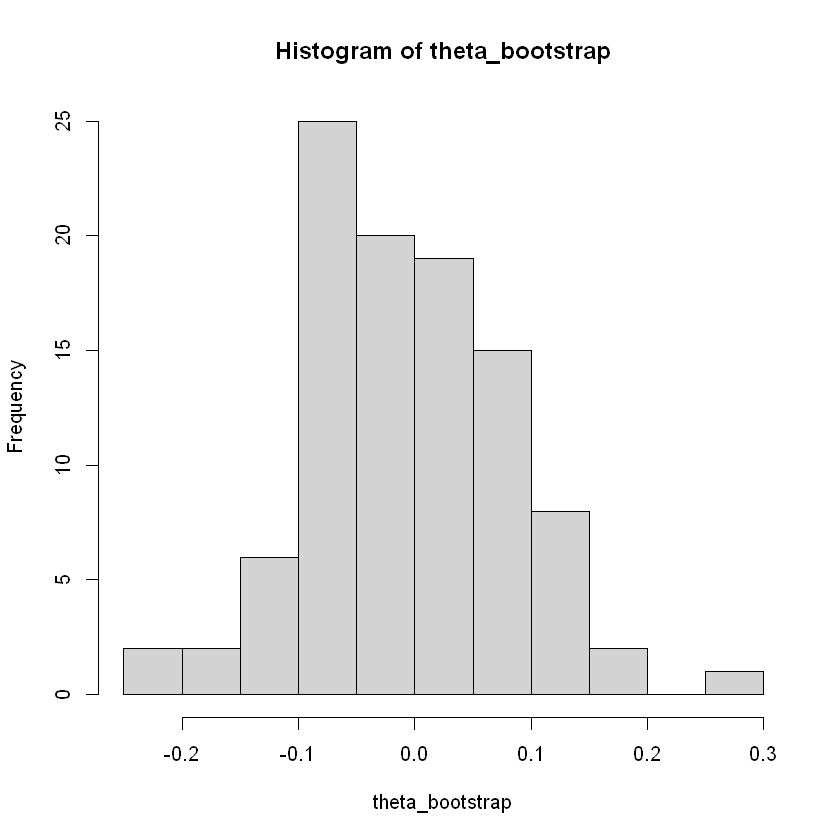

In [64]:
hist(theta_bootstrap)

O bootstrap não paramétrico deu errado, como o esperado.

### Questão 2

In [65]:
Questao2 <- function(B=20,T=100,beta=1,phi=0,theta=0.3,R=2)
    {
    
    theta_estimado<-numeric(R)
    mean_theta_bootstrap<-numeric(R)
    IC_bootstrap <- vector("list", R)

    for (r in 1:R)
        {
        Theta_bootstrap<-numeric(B)

        Amostra_original<-simulate_glarma(T=100,beta=1,phi=0,theta=0.3,x=NULL)
        X <- Amostra_original$x
        X <- as.matrix(X)
        colnames(X) <- "Intercept"

        result=glarma(Amostra_original$y, X, phiLags = NULL ,thetaLags = c(1), type = "Poi")
        theta_estimado[r]<-result$delta[2]
        
        e<-Amostra_original$e
        e_boot <- replicate(B, sample(e, size = T, replace = TRUE))
        
        Theta_bootstrap<-bootstrap_n_parametrico(e_boot=e_boot,B=20,mu_init=Amostra_original$mu,y=Amostra_original$y,X=X)
        
        mean_theta_bootstrap[r] <- mean(Theta_bootstrap)
        
        IC_bootstrap[[r]]<-quantile(Theta_bootstrap, probs = c(0.025, 0.975))
        }
    return(list('theta_estimado'=theta_estimado,'mean_theta_bootstrap'=mean_theta_bootstrap,'IC_bootstrap'=IC_bootstrap))
    } 

Testando as funções:

In [66]:
MM_bootstrap_n_parametrico<-Questao2()

In [67]:
MM_bootstrap_n_parametrico

$theta_estimado
[1] 0.2789253 0.3163217

$mean_theta_bootstrap
[1] 0.000663816 0.030683903

$IC_bootstrap
$IC_bootstrap[[1]]
       2.5%       97.5% 
-0.08570347  0.08327489 

$IC_bootstrap[[2]]
       2.5%       97.5% 
-0.08132567  0.30774680

In [68]:
conferindo_cobertura_bootstrap2 <- function(B = 20, T = 100, beta = 1, phi = 0, theta = 0.3, R = 100) {
  
  resultado <- Questao2(B = B, T = T, beta = beta, phi = phi, theta = theta, R = R)

  theta_estimado <- resultado$theta_estimado
  IC_bootstrap <- resultado$IC_bootstrap
  
  dentro_do_intervalo <- logical(R)
  
  for (r in 1:R) {
    intervalo <- IC_bootstrap[[r]]
    dentro_do_intervalo[r] <- (theta >= intervalo[1]) && (theta <= intervalo[2])
  }

  cobertura_percentual <- mean(dentro_do_intervalo) * 100
  
  return(list(
    cobertura_percentual = cobertura_percentual,
    total_dentro = sum(dentro_do_intervalo),
    total_r = R
  ))
}


In [69]:
conferindo_cobertura_bootstrap2(R=2)

$cobertura_percentual
[1] 0

$total_dentro
[1] 0

$total_r
[1] 2

Já sabemos que o algorítmo está errado, logo fiz poucas iterações.

# Questão 3

criando as funções:

In [31]:
prev_glarma <- function(y, x, beta, theta, h = 2, seed = NULL) {

 futuro_x <- rep(mean(x[, 1], na.rm = TRUE), h)

  if (!is.null(seed)) set.seed(seed)
  
  T <- length(y)
  mu <- numeric(T)
  e <- numeric(T)
  z <- numeric(T)
  
  #passo 1, recontruir z,e,mu
    
  for (t in 1:T) {
      
    z_t <- if (t > 1) e[t - 1] * theta else 0
      
    eta <- beta * x[t] + z_t
    mu[t] <- exp(eta)
    e[t] <- (y[t] - mu[t]) / sqrt(mu[t])
    z[t] <- z_t
  }
  
  # passo 2, previsão
  y_pred <- numeric(h)
  mu_pred <- numeric(h)
    
  z_t <- z[T]
  e_t <- e[T]

  for (i in 1:h) {
    
    z_t <- e_t * theta
      
    eta <- beta * futuro_x[i] + z_t
    mu_pred[i] <- exp(eta)

    y_pred[i] <- rpois(1, lambda = mu_pred[i])  
    e_t <- (y_pred[i] - mu_pred[i]) / sqrt(mu_pred[i]) 

  }
  
  return(data.frame(
    step = 1:h,
    x = futuro_x,
    mu = mu_pred,
    y_pred = y_pred
  ))
}


In [32]:
intervalo_preditivo_bootstrap <- function(H=2,T=100,B=20, beta = 1, phi = 0, theta = 0.3){
    
    theta_boot <- numeric(B)
    Y_pred <- matrix(NA, nrow = H, ncol = B)
    IC_pred <- vector("list", H)
    
    
    x_train <- rep(1,(T-H))
    x_train <- as.matrix(x_train)
    colnames(x_train) <- "Intercept"
        
    boot <- bootstrap_parametrico(T=100,B=20, beta = 1, phi = 0, theta = 0.3)
    
    Y <- boot$Amostra_original
    Y_train = Y[1:(T-H)]
    Y_test = Y[(T-H+1):T]

    
    theta_boot<-boot$Theta_bootstrap
    
    for (b in 1:B)
        {
        prev<-prev_glarma(y=Y_train,x=x_train,beta=beta,theta=theta_boot[b],h=H)
        Y_pred[,b]<-prev$y_pred
        }
    for (h in 1:H)
        {
        IC_pred[[h]]<-quantile(Y_pred[h,], probs = c(0.025, 0.975))
        }
    return(list('Y_test'=Y_test,'IC_pred'=IC_pred))
}

In [33]:
conferindo_IP <- function(B = 20, T = 100, beta = 1, phi = 0, theta = 0.3, H  = 3) {
  
  resultado <- intervalo_preditivo_bootstrap(H=H,T=T,B=20, beta = beta, phi = phi, theta = theta)

  Y_test <- resultado$Y_test
  IC_pred <- resultado$IC_pred
  
  dentro_do_intervalo <- logical(H)
  
  for (h in 1:H) {
    intervalo <- IC_pred[[h]]
    dentro_do_intervalo[h] <- (Y_test[h] >= intervalo[1]) && (Y_test[h] <= intervalo[2])
  }

  cobertura_percentual <- mean(dentro_do_intervalo) * 100
  
  return(list(
    Intervalos=resultado,
    total_dentro = sum(dentro_do_intervalo),
    total_H = H    
  ))
}


In [34]:
conferindo_IP(H=5)

$Intervalos
$Intervalos$Y_test
[1] 1 5 6 3 4

$Intervalos$IC_pred
$Intervalos$IC_pred[[1]]
 2.5% 97.5% 
    0     3 

$Intervalos$IC_pred[[2]]
 2.5% 97.5% 
    0     4 

$Intervalos$IC_pred[[3]]
 2.5% 97.5% 
    0     6 

$Intervalos$IC_pred[[4]]
 2.5% 97.5% 
  0.0   8.2 

$Intervalos$IC_pred[[5]]
 2.5% 97.5% 
    0     6 



$total_dentro
[1] 4

$total_H
[1] 5

Para H passos, Y_teste está dentro dos intervalos de confiança feito com o bootstrap paramétrico.